In [6]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import preprocessing, utils
import os
import yaml

# Retrieve data train

In [7]:
knowledgebase = pd.read_excel('https://raw.githubusercontent.com/AndiAlifs/FLUENT-Chatbot-2023/main/KnowledgeBaseFilkom.xlsx', engine='openpyxl')
knowledgebase.head()

,No,Contributor,Topik/Tag,Pertanyaan,Jenis,Jawaban,Link Jawaban,Keterangan Tambahan
0,0.0,Fitra,Informasi Dosen,email Fitra A. Bachtiar,Statis,fitra.bachtiar[at]ub.ac.id,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
1,NaN,NaN,NaN,NIK/NIP Fitra A. Bachtiar,Statis,198406282019031006,NaN,NaN
2,NaN,NaN,NaN,nama lengkap Fitra A. Bachtiar,Statis,Dr.Eng. Fitra A. Bachtiar,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
3,NaN,NaN,NaN,Departemen Fitra A. Bachtiar,Dinamis,Departemen Teknik Informatika,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN
4,NaN,NaN,NaN,Program Studi Fitra A. Bachtiar,Dinamis,S2 Ilmu Komputer,https://filkom.ub.ac.id/sdm-dosen/?search_f7a8...,NaN


In [8]:
qa_paired = knowledgebase.drop(columns=knowledgebase.columns.drop(['Pertanyaan', 'Jawaban']))
qa_paired.dropna(inplace=True)
qa_paired

,Pertanyaan,Jawaban
0,email Fitra A. Bachtiar,fitra.bachtiar[at]ub.ac.id
1,NIK/NIP Fitra A. Bachtiar,198406282019031006
2,nama lengkap Fitra A. Bachtiar,Dr.Eng. Fitra A. Bachtiar
3,Departemen Fitra A. Bachtiar,Departemen Teknik Informatika
4,Program Studi Fitra A. Bachtiar,S2 Ilmu Komputer
...,...,...
1229,Apa Manfaat Konseling FILKOM ?,1. Masalah ditangani oleh ahli yang kompeten d...
1230,Berikan informasi mengenai Layanan Konseling,Informasi mengenai Layanan Konseling dapat dia...
1231,Siapa Konselor Bimbingan dan Konseling di FILK...,Ada 2 konselor Bimbingan dan Konseling di FILK...
1232,Siapa Koordinator Konselor Sebaya ?,Koordinator Konselor Sebaya adalah Muhammad Da...


# RNN Based

## Preprocessing Data

In [9]:
# remove all the punctuation from qa_paired
qa_paired['Pertanyaan'] = qa_paired['Pertanyaan'].str.replace('[^\w\s]',' ').str.lower()
qa_paired['Jawaban'] = qa_paired['Jawaban'].str.replace('[^\w\s]',' ').str.lower()

In [10]:
vocab = sorted(set(" ".join(qa_paired['Pertanyaan'] +" " + qa_paired['Jawaban']).split()))

In [11]:
questions = qa_paired['Pertanyaan']

answers = list()
for i in range( len(qa_paired['Jawaban']) ) :
    answers.append( '<START> ' + " ".join(qa_paired['Jawaban'].iloc[i].split()) + ' <END>' )

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts( questions + answers )
VOCAB_SIZE = len( tokenizer.word_index )+1
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 2600


### Encoder-Decoder

In [12]:
from gensim.models import Word2Vec
import re

In [13]:
vocab = []
for word in tokenizer.word_index:
  vocab.append(word)

def tokenize(sentences):
  tokens_list = []
  vocabulary = []
  for sentence in sentences:
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    tokens = sentence.split()
    vocabulary += tokens
    tokens_list.append(tokens)
  return tokens_list, vocabulary

In [14]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences( questions )
maxlen_questions = max( [len(x) for x in tokenized_questions ] )
padded_questions = preprocessing.sequence.pad_sequences( tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print(encoder_input_data.shape, maxlen_questions)

(1198, 13) 13


In [15]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
maxlen_answers = max( [ len(x) for x in tokenized_answers ] )
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
decoder_input_data = np.array( padded_answers )
print( decoder_input_data.shape , maxlen_answers )

(1198, 294) 294


In [16]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences( answers )
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences( tokenized_answers , maxlen=maxlen_answers , padding='post' )
onehot_answers = utils.to_categorical( padded_answers , VOCAB_SIZE )
decoder_output_data = np.array( onehot_answers )
print( decoder_output_data.shape )

(1198, 294, 2600)


## Modelling

In [17]:
from keras.callbacks import ModelCheckpoint

# define the checkpoint
checkpoint = ModelCheckpoint('model_weights.h5', monitor='loss', verbose=1, save_best_only=True, mode='min')

In [18]:
# reset model
tf.keras.backend.clear_session()

In [19]:
encoder_inputs = tf.keras.layers.Input(shape=( maxlen_questions , ))
encoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True ) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM( 500 , return_state=True )( encoder_embedding )
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=( maxlen_answers ,  ))
decoder_embedding = tf.keras.layers.Embedding( VOCAB_SIZE, 500 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM( 500 , return_state=True , return_sequences=True )
decoder_outputs , _ , _ = decoder_lstm ( decoder_embedding , initial_state=encoder_states )
decoder_dense = tf.keras.layers.Dense( VOCAB_SIZE , activation=tf.keras.activations.softmax ) 
output = decoder_dense ( decoder_outputs )

model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output )
model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 294)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 13, 500)      1300000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 294, 500)     1300000     input_2[0][0]                    
______________________________________________________________________________________________

In [75]:
history = model.fit([encoder_input_data , decoder_input_data], 
                    decoder_output_data, 
                    batch_size=50, 
                    epochs=100,
                    callbacks=[checkpoint] ) 
# model.save( 'model.h5' )

Epoch 1/100
24/24 [==============================] - 43s 2s/step - loss: 0.4465

Epoch 00001: loss improved from inf to 0.44654, saving model to model_weights.h5
Epoch 2/100
24/24 [==============================] - 37s 2s/step - loss: 0.3896

Epoch 00002: loss improved from 0.44654 to 0.38959, saving model to model_weights.h5
Epoch 3/100
24/24 [==============================] - 36s 2s/step - loss: 0.3584

Epoch 00003: loss improved from 0.38959 to 0.35843, saving model to model_weights.h5
Epoch 4/100
24/24 [==============================] - 37s 2s/step - loss: 0.3326

Epoch 00004: loss improved from 0.35843 to 0.33257, saving model to model_weights.h5
Epoch 5/100
24/24 [==============================] - 37s 2s/step - loss: 0.3129

Epoch 00005: loss improved from 0.33257 to 0.31286, saving model to model_weights.h5
Epoch 6/100
24/24 [==============================] - 37s 2s/step - loss: 0.2912

Epoch 00006: loss improved from 0.31286 to 0.29119, saving model to model_weights.h5
Epoch 7/

In [32]:
# load model best weights
model.load_weights('model_weights.h5')

<AxesSubplot:>

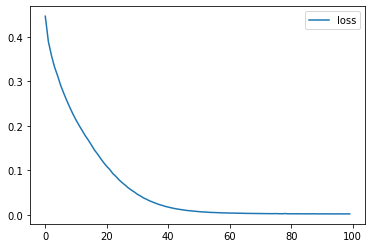

In [77]:
visualization = pd.DataFrame(history.history)
visualization[['loss']].plot()

## Test the chatbot

In [33]:
def make_inference_models():
    
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    decoder_state_input_h = tf.keras.layers.Input(shape=( 500 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=( 500 ,))
    
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_embedding , initial_state=decoder_states_inputs)
    
    decoder_states = [state_h, state_c]

    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model(
        [decoder_inputs] + decoder_states_inputs,
        [decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

In [34]:
def str_to_tokens( sentence : str ):

    words = sentence.lower().split()
    tokens_list = list()

    for word in words:
        tokens_list.append( tokenizer.word_index[ word ] ) 
    return preprocessing.sequence.pad_sequences( [tokens_list] , maxlen=maxlen_questions , padding='post')


In [35]:
# disable warning tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

enc_model , dec_model = make_inference_models()

quest = input("Enter question : ")

states_values = enc_model.predict( str_to_tokens(quest) )
empty_target_seq = np.zeros( ( 1 , 1 ) )
empty_target_seq[0, 0] = tokenizer.word_index['start']
stop_condition = False
decoded_translation = ''
while not stop_condition :
    dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
    sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
    sampled_word = None
    for word , index in tokenizer.word_index.items() :
        if sampled_word_index == index :
            decoded_translation += ' {}'.format( word )
            sampled_word = word
    
    if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
        stop_condition = True
        
    empty_target_seq = np.zeros( ( 1 , 1 ) )  
    empty_target_seq[ 0 , 0 ] = sampled_word_index
    states_values = [ h , c ] 

print("Pertanyaan : ", quest.strip())
print("Jawaban : ", decoded_translation.strip())

Pertanyaan :  informasi kalender akademik
Jawaban :  https docs google com spreadsheets d 1wiefeh2rbdljzyznv8 lmbv8azejqqqtndkdntwv63g edit gid 213487730 end


## Evaluation

In [45]:
!pip install rouge

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [46]:
import sacrebleu
from sacrebleu.metrics import BLEU
import bert_score
from nltk.translate.bleu_score import sentence_bleu
from torchmetrics import BLEUScore, SacreBLEUScore
from torchmetrics.text.bert import BERTScore
import rouge as rouge_lib

In [67]:
def calculate_rouge(preds, real):
    scorer = rouge_lib.Rouge()
    scorer.get_scores(preds,
                    real.tolist(),
                    avg=True,
                    ignore_empty=True)
    return scorer
    
def calculate_bertscore(preds, real):
    bertscorer = bert_score.BERTScorer(idf=True,
                      lang='en',
                      rescale_with_baseline=True,
                      use_fast_tokenizer=True,
                      device='cuda')

    bertscorer.compute_idf([r for rs in preds for r in rs])
    prf = bertscorer.score(preds, real.tolist(), batch_size=64)
    return {key: scores.mean().item() for key, scores in zip(('p', 'r', 'f'), prf)}
    
def calculate_bleu(preds, questions, answers):
    bleu_score_1 = 0
    bleu_score_2 = 0
    bleu_score_3 = 0
    bleu_score_4 = 0
    bleu_score_all = 0

    num_of_rows_calculated = 0

    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        try:
            refs = [real_answer.split(' ')]
            hyp = preds[i].split(' ')

            bleu_score_1 += sentence_bleu(refs, hyp, weights=(1,0,0,0))
            bleu_score_2 += sentence_bleu(refs, hyp, weights=(0,1,0,0))
            bleu_score_3 += sentence_bleu(refs, hyp, weights=(0,0,1,0))
            bleu_score_4 += sentence_bleu(refs, hyp, weights=(0,0,0,1))
            bleu_score_all += sentence_bleu(refs, hyp, weights=(.25,.25,.25,.25))

            num_of_rows_calculated+=1
        except:
            continue

    results = {"1-gram": (bleu_score_1/num_of_rows_calculated),
                "2-gram": (bleu_score_2/num_of_rows_calculated),
                "3-gram": (bleu_score_3/num_of_rows_calculated),
                "4-gram": (bleu_score_all/num_of_rows_calculated)}
    
    return results

def calculate_bleu_final(preds, questions, answers):
    for i, (question, real_answer) in enumerate(zip(questions, answers)):
        print(i)
        print("Pertanyaan : ", question.strip())
        print("Jawaban : ", preds[i].strip())
        print("Jawaban Sebenarnya : ", real_answer.strip())

In [107]:
real_questions = questions
real_answers = answers
pred_answers = []

for i, question in enumerate(real_questions):
    real_answers[i] = real_answers[i].replace('<START>', '').replace('<END>', '').strip()
    states_values = enc_model.predict( str_to_tokens(question) )
    empty_target_seq = np.zeros( ( 1 , 1 ) )
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''
    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([ empty_target_seq ] + states_values )
        sampled_word_index = np.argmax( dec_outputs[0, -1, :] )
        sampled_word = None
        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += ' {}'.format( word )
                sampled_word = word
        
        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True
            
        empty_target_seq = np.zeros( ( 1 , 1 ) )  
        empty_target_seq[ 0 , 0 ] = sampled_word_index
        states_values = [ h , c ] 

    pred_answers.append(decoded_translation.replace('end', '').strip())


In [108]:
all_score =  calculate_bleu(pred_answers, real_questions, real_answers)
print(all_score)

/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/acrig/.local/lib/python3.6/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunctio

{'1-gram': 0.881439926191369, '2-gram': 0.857337447733578, '3-gram': 0.8146137552774978, '4-gram': 0.7286819933377803}


In [110]:
rata2 = (all_score['1-gram'] + all_score['2-gram'] + all_score['3-gram'] + all_score['4-gram'])/4
print(rata2)

0.8205182806350563
